In [1]:
import pandas as pd
import numpy as np

#import matplotlib as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from rdkit import Chem

# FEATURES
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem # For Morgan Fingerprint (Circular Fingerprints)
from rdkit.Chem import MACCSkeys # For MACCS keys

# SCALING DATA
from sklearn.preprocessing import scale

# For splitting data into training and test sets.
from sklearn.model_selection import train_test_split

# For processing how well our methods have classified our data
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score,roc_auc_score

# Principal Component Analysis (PCA)
from sklearn.decomposition import PCA

# Logistic Regression ML Model
from sklearn.linear_model import LogisticRegression

In [2]:
####################################################################
###
###    User Defined Helper Functions
###
####################################################################

# FUNCTION LOAD_DATA
# Load the data from the csv file in the [data] folder. We separate 
# the molecule data from the "explosive" labes and return the labels
# an a molecules from SMILES representation for each molecule in the 
# dataset
def load_data(data_file):
    mol_df = pd.read_csv(data_file)

    smiles = mol_df['smiles']
    labels = mol_df['labels']
    
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    
    return mols, labels

# FUNCTION GEN_FPRINTS
# Generate molecule fingerprints for each molecule in an input list
def gen_fprints(mols):
    f_prints = np.array([Chem.RDKFingerprint(mol).ToBinary() for mol in mols])  
    return f_prints

# FUNCTION gen_MACCS 
# Generate the MACCS keys for each molecule in an input list of molecules
def gen_MACCS(mols):
    MACCS_keys = np.array([MACCSkeys.GenMACCSKeys(mol) for mol in mols])
    return MACCS_keys

# FUNCTION gen_morgan_prints
# Generates Morgan finger prints for each molecule in an input list of molecules
def gen_morgan_prints(mols,radius):
    morgan_prints = np.array([AllChem.GetMorganFingerprintAsBitVect(mol,radius,nBits=1024) for mol in mols])
    return morgan_prints

In [3]:
def getKeyFromBond(bond):
    atom1 = int(bond.GetBeginAtom().GetAtomicNum())
    atom2 = int(bond.GetEndAtom().GetAtomicNum())

    if atom1 > atom2:
        atom1, atom2 = atom2, atom1

    bondType = int(bond.GetBondTypeAsDouble() * 2 - 2)
    key = atom1 | (atom2 << 8) | (bondType << 16)

    return key

def formatMolecule(ID):
    pt = Chem.GetPeriodicTable()
    atom1 = pt.GetElementSymbol(int(ID & 255))
    atom2 = pt.GetElementSymbol(int((ID >> 8) & 255))
    bondType = ['-', ':', '=', 'err', '#'][(ID >> 16) & 255]
    return '%s%s%s' % (atom1,bondType,atom2)

def gen_nathan_prints(mols):
    # this dictionary is responsible for assigning a unique ID (index) to
    # every unique bond.  The bonds are assigned incrementing IDs as discovered
    bondIDs = dict()
    numUniqueBonds = 0
    
    for molecule in mols:
        for bond in molecule.GetBonds():
            key = getKeyFromBond(bond)
            if key not in bondIDs:
                bondIDs[key] = numUniqueBonds
                numUniqueBonds += 1
    
    # list of numpy byte arrays representing the feature vector of each molecule
    fingerprints = []

    for molecule in mols:
        # One molecule has 105 carbon-carbon single bonds, so the fingerprint
        # format is set to preserve up to that many occurances of any unique bond
            
        # each fingerprint requires 1 byte to store the count of each unique bond type
        # plus the extra 2 bytes store the molecule's molar mass
        fingerprint = np.zeros(numUniqueBonds + 2, np.uint8)
        
        for bond in molecule.GetBonds():
            key = getKeyFromBond(bond)
            index = bondIDs[key]
            fingerprint[index] += 1
        
        # the heaviest molecule in our dataset weights 3431.9089999999887 g/mol
        # encode the weight with 1/5 increments of fractional value
        # in the last 2 bytes of the finger print / feature vector
        weight = Descriptors.MolWt(molecule)
        intWeight = round(weight * 5)
        fingerprint[numUniqueBonds] = intWeight & 255
        fingerprint[numUniqueBonds + 1] = (intWeight >> 8) & 255
        
        fingerprints.append(fingerprint)
    
    # create a mapping from bond ID to bond key to aid feature importance
    sourceMap = np.zeros(numUniqueBonds, np.uint32)
    for k, v in bondIDs.items():
        sourceMap[v] = k
    
    return fingerprints, sourceMap

In [4]:
data_file = 'data/molecule_data.csv'
mols, labels = load_data(data_file)

RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:27:25] WARNING: not removing hydrogen atom without neighbors


In [5]:
uniqueAtoms = set()
for molecule in mols:
    for atom in molecule.GetAtoms():
        uniqueAtoms.add(atom.GetSymbol())
        
print(len(uniqueAtoms), "unique atoms:", uniqueAtoms, end="\n\n")

extreme = {
    'count': 0,
    'key': 0,
    'moleculeIndex': 0
}

uniqueBonds = set()

for i in range(len(mols)):
    molecule = mols[i]
    bondCounts = dict()
    for bond in molecule.GetBonds():
        key = getKeyFromBond(bond)
        uniqueBonds.add(key)
        
        if key in bondCounts:
            bondCounts[key] += 1
        else:
            bondCounts[key] = 1

        if extreme['count'] < bondCounts[key]:
            extreme = {
                'count': bondCounts[key],
                'key': key,
                'moleculeIndex': i
            }
        
print("spread sheet row:", extreme['moleculeIndex'] + 2, ", molecule has", extreme['count'], "counts of", formatMolecule(extreme['key']), end='\n\n')

print(len(uniqueBonds), "unique bonds:", [formatMolecule(key) for key in uniqueBonds])

38 unique atoms: {'Br', 'B', 'Sn', 'Cr', 'Cl', 'Si', 'Pb', 'C', 'Ir', 'F', 'Pt', 'H', 'Fe', 'In', 'Sr', 'S', 'N', 'I', 'K', 'Zn', 'Ti', 'Na', 'Hg', 'P', 'Ce', 'Ag', 'Rb', 'Mg', 'Ca', 'Bi', 'Se', 'Co', 'As', 'Ge', 'Tc', 'Kr', 'Al', 'O'}

spread sheet row: 2460 , molecule has 105 counts of C-C

80 unique bonds: ['B-C', 'C:C', 'N=O', 'N-O', 'C-C', 'C-O', 'C=O', 'O=S', 'O-S', 'O=Si', 'P=S', 'S-S', 'P-S', 'Cl-Hg', 'Cl-Cr', 'Si-Si', 'Cl-Fe', 'Cl-Zn', 'S=Se', 'Cl-Sn', 'C-As', 'O=As', 'O-As', 'C-Br', 'C=C', 'C#C', 'B-O', 'C:O', 'C#O', 'N:O', 'O-O', 'O=Mg', 'C-Si', 'O-Si', 'C-S', 'C=S', 'C:S', 'C-Hg', 'N-S', 'N:S', 'N-Hg', 'O-Hg', 'F-S', 'N-Pb', 'C-I', 'O=Ca', 'O=Ti', 'C-N', 'N:N', 'O=Tc', 'C:N', 'N-N', 'O-Al', 'C-P', 'N-P', 'O-P', 'O=P', 'N-Cl', 'Cl-Co', 'S-As', 'Cl-In', 'C-Ge', 'O=Ge', 'O-Ge', 'C-Se', 'I-I', 'O-Se', 'O=Se', 'C=N', 'C#N', 'N=N', 'N#N', 'C-F', 'N-F', 'F-P', 'C-Cl', 'O-Cl', 'N-Sn', 'O-Bi', 'O=Bi']


In [6]:
# load different molecular features separately
##############################################
#rdk_features    = gen_fprints(mols)
#maccs_features  = gen_MACCS(mols)
#morgan_features = gen_morgan_prints(mols,radius=18)
nathan_features, bondIDSourceMap = gen_nathan_prints(mols)

Feature: 4, N=O, Score: 2.14294
Feature: 18, O-O, Score: 1.41701
Feature: 17, N=N, Score: 1.19867
Feature: 19, O-Cl, Score: 1.07127
Feature: 22, N:O, Score: 1.02593
Feature: 30, N-Cl, Score: 0.96279
Feature: 2, N:N, Score: 0.87438
Feature: 6, N-N, Score: 0.73235
Feature: 23, C#C, Score: 0.62476
Feature: 5, N-O, Score: 0.39065
Feature: 20, C#N, Score: 0.27131
Feature: 26, C-Br, Score: 0.16193
Feature: 12, N#N, Score: 0.15035
Feature: 27, O-P, Score: 0.13388
Feature: 25, N-F, Score: 0.12446
Feature: 14, O-S, Score: 0.02814
Feature: 21, N-Pb, Score: 0.00000
Feature: 44, Cl-Co, Score: 0.00000
Feature: 50, O=Si, Score: 0.00000
Feature: 51, C-Ge, Score: 0.00000
Feature: 52, O=Ge, Score: 0.00000
Feature: 53, O-Ge, Score: 0.00000
Feature: 56, O=Mg, Score: 0.00000
Feature: 59, O-Si, Score: 0.00000
Feature: 61, Si-Si, Score: 0.00000
Feature: 70, N-Sn, Score: 0.00000
Feature: 71, Cl-Sn, Score: 0.00000
Feature: 73, Cl-In, Score: 0.00000
Feature: 74, Cl-Zn, Score: 0.00000
Feature: 76, Cl-Fe, Score:

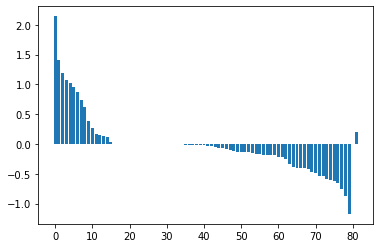

Confusion Matrix
[[1178    3]
 [   4   72]]

Recall
0.9473684210526315

Accuracy
0.994431185361973

F1 Score
0.9536423841059603

ROC AUC Score
0.9724141004501091


In [7]:
#########################################################################
#
# Logistic Regression [WITHOUT] PCA
#
#########################################################################

# Split data for [training] and [testing]
nathan_train, nathan_test, label_train, label_test = train_test_split(nathan_features, labels, \
                                                                test_size=0.3, shuffle=True)

# Train Logistic Regression model using PC transformed Nathan features
LRmodelPC = LogisticRegression(max_iter=10000)
LRmodelPC.fit(nathan_train, label_train)

            # get importance
            importance = LRmodelPC.coef_[0]


            # summarize feature importance in order of importance
            bondCountFeatures = list(enumerate(importance))[:-2]
            bondCountFeatures.sort(key=lambda x: x[1], reverse=True)

            for i,score in bondCountFeatures:
                ID = bondIDSourceMap[i]
                bondDisplay = formatMolecule(ID)
                print('Feature: %0d, %s, Score: %.5f' % (i,bondDisplay,score))

            print('\nFeature: %0d, Weight low byte, Score: %.5f' % (len(importance) - 2, importance[-2]))
            print('Feature: %0d, Weight high byte, Score: %.5f' % (len(importance) - 1, importance[-1]))

            # plot feature importance in order of importance
            sortedImportance = list(map(lambda x: x[1], bondCountFeatures))
            sortedImportance.extend(list(importance)[-2:])
            plt.bar([x for x in range(len(importance))], sortedImportance)
            plt.show()

pred = LRmodelPC.predict(nathan_test)

# Model Generalizability Analysis
accuracy = accuracy_score(label_test, pred)
conf_matrix = confusion_matrix(label_test, pred)
F1Score = f1_score(label_test,pred)
roc_auc = roc_auc_score(label_test,pred)
recall = recall_score(label_test,pred)

print('Confusion Matrix')
print(conf_matrix)

print('\nRecall')
print(recall)  

print('\nAccuracy')
print(accuracy)  

print('\nF1 Score')
print(F1Score)

print('\nROC AUC Score')
print(roc_auc)